In [1]:
import os
import keras
import librosa
import numpy as np

/home/cc/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#load the variables
x_train=np.load('x_train3D30.npy')
x_test=np.load('x_test3D30.npy')
y_trainHot=np.load('y_trainHot3D30.npy')
y_testHot=np.load('y_testHot3D30.npy')

In [51]:
# Quick fix. I am adding virtual axes to the training and test 'x' distributions to make it 4D. 
# This is an easy hack to convert from one dimension to another.
# Please find below a complete example of MFCC data trained using a CNN.

In [3]:
xtr = x_train[:,:,:, np.newaxis]
xte = x_test[:,:,:, np.newaxis]

In [4]:
xtr.shape

(5586, 80, 2500, 1)

In [5]:
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.utils.data_utils import get_file
from keras.layers import Input, Dense
from keras.optimizers import Adam


def MusicTaggerCNN(input_tensor=None, num_class=8):
    
    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        input_shape = (1, 80, 2500)
    else:
        input_shape = (80, 2500, 1)

    if input_tensor is None:
        melgram_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            melgram_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            melgram_input = input_tensor

    # Determine input axis
    if K.image_dim_ordering() == 'th':
        channel_axis = 1
        freq_axis = 2
        time_axis = 3
    else:
        channel_axis = 3
        freq_axis = 1
        time_axis = 2

    # Input block
    x = BatchNormalization(axis=freq_axis, name='bn_0_freq')(melgram_input)

    # Conv block 1
    x = Convolution2D(64, (3, 3), padding='same', name='conv1')(x)
    x = BatchNormalization(axis=channel_axis, name='bn1')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(2, 4), name='pool1')(x)

    # Conv block 2
    x = Convolution2D(128, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(axis=channel_axis, name='bn2')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(2, 4), name='pool2')(x)

    # Conv block 3
    x = Convolution2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(axis=channel_axis, name='bn3')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(2, 4), name='pool3')(x)

    # Conv block 4
    x = Convolution2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(axis=channel_axis, name='bn4')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(3, 5), name='pool4')(x)

    # Conv block 5
    x = Convolution2D(64, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(axis=channel_axis, name='bn5')(x)
    x = ELU()(x)
    #x = MaxPooling2D(pool_size=(4, 4), name='pool5')(x)

    # Output
    x = Flatten()(x)
    x = Dense(num_class, activation='softmax', name='output')(x)

    # Create model
    model = Model(melgram_input, x)
    return model

In [6]:
model = MusicTaggerCNN(num_class=8)

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 2500, 1)       0         
_________________________________________________________________
bn_0_freq (BatchNormalizatio (None, 80, 2500, 1)       320       
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 2500, 64)      640       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 80, 2500, 64)      256       
_________________________________________________________________
elu_1 (ELU)                  (None, 80, 2500, 64)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 40, 625, 64)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 40, 625, 128)      73856     
__________

In [9]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(lr=0.01))

In [10]:
model.fit(xtr, y_trainHot, epochs=5, batch_size=100)

Epoch 1/5
5586/5586 [==============================] - 3135s 561ms/step - loss: 2.2477 - acc: 0.2789
Epoch 2/5
5586/5586 [==============================] - 2473s 443ms/step - loss: 1.7250 - acc: 0.3815
Epoch 3/5
5586/5586 [==============================] - 2823s 505ms/step - loss: 1.6150 - acc: 0.4230
Epoch 4/5
5586/5586 [==============================] - 2230s 399ms/step - loss: 1.5322 - acc: 0.4642
Epoch 5/5
5586/5586 [==============================] - 2074s 371ms/step - loss: 1.4381 - acc: 0.4980


In [11]:
#describe genres by label number
dict_characters={0: 'Hip-Hop',1: 'Pop',2: 'Folk',3: 'Rock',4: 'Experimental',5: 'International',6: 'Instrumental',7: 'Electronic'}

In [12]:
#Confuson Matrix function
import matplotlib.pylab as plt
import itertools
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


               precision    recall  f1-score   support

      Hip-Hop       0.40      0.83      0.54       301
          Pop       0.00      0.00      0.00       310
         Folk       0.20      0.29      0.24       292
         Rock       0.12      0.01      0.01       288
 Experimental       0.00      0.00      0.00       340
International       0.89      0.09      0.16       284
 Instrumental       0.21      0.89      0.34       300
   Electronic       0.25      0.01      0.01       279

  avg / total       0.25      0.26      0.16      2394



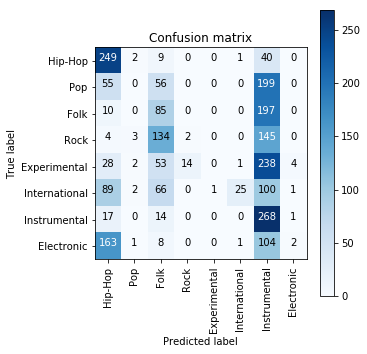

In [13]:
#compute predictions for confusion matrix
Y_pred = model.predict(xte)
print('\n', sklearn.metrics.classification_report(np.where(y_testHot > 0)[1], np.argmax(Y_pred, axis=1),target_names=list(dict_characters.values())), sep='')
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_testHot,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    
#plot confusion matrix
plot_confusion_matrix(cm=confusion_mtx,classes=list(dict_characters.values()))